In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [67]:
# 必要モジュール
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import trange

# ───────────────────────────────────────────────────────────
# 1) 時刻埋め込み
# ───────────────────────────────────────────────────────────
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(10000.0, device=t.device)) 
            * torch.arange(half, device=t.device) / (half - 1)
        )
        args = t[:, None].float() * freqs[None]
        return torch.cat([args.sin(), args.cos()], dim=-1)

# ───────────────────────────────────────────────────────────
# 2) FiLM付き ResBlock
# ───────────────────────────────────────────────────────────
class ResBlockFiLM(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch*2)
        self.cond_mlp = nn.Linear(cond_emb_dim, out_ch*2)
        self.nin = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, t_emb, cond_emb):
        B, C, H, W = x.shape
        # FiLM parameters
        gamma_t, beta_t = self.time_mlp(t_emb).chunk(2, dim=-1)
        gamma_c, beta_c = self.cond_mlp(cond_emb).chunk(2, dim=-1)
        # conv1 + FiLM + activation
        h = self.conv1(x)
        h = h * (1 + gamma_t[:,:,None,None]) + beta_t[:,:,None,None]
        h = h * (1 + gamma_c[:,:,None,None]) + beta_c[:,:,None,None]
        h = F.silu(h)
        # conv2
        h = self.conv2(h)
        return h + self.nin(x)

# ───────────────────────────────────────────────────────────
# 3) SimpleUNet 定義
# ───────────────────────────────────────────────────────────
class SimpleUNet(nn.Module):
    def __init__(self, cond_dim=128, time_emb_dim=128):
        super().__init__()
        # 時刻埋め込み、条件埋め込み
        self.time_emb = SinusoidalPosEmb(time_emb_dim)
        self.cond_proj = nn.Sequential(
            nn.Linear(5*1000*70, cond_dim),
            nn.SiLU(),
            nn.Linear(cond_dim, cond_dim),
        )
        # 各 ResBlock
        self.rb1 = ResBlockFiLM(1,   64,  time_emb_dim, cond_dim)
        self.rb2 = ResBlockFiLM(64, 128,  time_emb_dim, cond_dim)
        self.rb3 = ResBlockFiLM(128,256,  time_emb_dim, cond_dim)
        self.rb4 = ResBlockFiLM(256,128,  time_emb_dim, cond_dim)
        self.rb5 = ResBlockFiLM(128, 64,  time_emb_dim, cond_dim)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x, t, cond):
        B = x.size(0)
        t_emb = self.time_emb(t)            # → (B, time_emb_dim)
        cond_emb = self.cond_proj(cond)     # → (B, cond_dim)
        # encoder
        h1 = self.rb1(x, t_emb, cond_emb)   # [B,64,H,W]
        h2 = F.avg_pool2d(h1, 2)            # [B,64,H/2,W/2]
        h2 = self.rb2(h2, t_emb, cond_emb)  # [B,128,H/2,W/2]
        # bottleneck
        h3 = F.avg_pool2d(h2, 2)            # [B,128,H/4,W/4]
        h3 = self.rb3(h3, t_emb, cond_emb)  # [B,256,H/4,W/4]
        # decoder
        u1 = F.interpolate(h3, size=h2.shape[2:], mode='bilinear', align_corners=False)
        u1 = self.rb4(u1 + h2, t_emb, cond_emb)
        u2 = F.interpolate(u1, size=h1.shape[2:], mode='bilinear', align_corners=False)
        u2 = self.rb5(u2 + h1, t_emb, cond_emb)
        return self.out(u2)

# ───────────────────────────────────────────────────────────
# 4) スケジュール
# ───────────────────────────────────────────────────────────
def linear_beta_schedule(T):
    return torch.linspace(1e-4, 5e-3, T)
def get_alphas(betas):
    alphas = 1. - betas
    ab = torch.cumprod(alphas, dim=0)
    return ab.sqrt(), (1-ab).sqrt()

# ───────────────────────────────────────────────────────────
# 5) q_sample / p_sample 実装
# ───────────────────────────────────────────────────────────
def q_sample(x0, t, noise, sqrt_ab, sqrt_1m_ab):
    return (sqrt_ab[t][:,None,None,None] * x0
          + sqrt_1m_ab[t][:,None,None,None] * noise)

@torch.no_grad()
def p_sample(model, x, t, cond, betas, sqrt_ab, sqrt_1m_ab):
    eps_pred = model(x, t, cond)
    beta_t    = betas[t]
    alpha_t   = 1 - beta_t
    ab_t      = sqrt_ab[t]**2
    ab_prev   = sqrt_ab[t-1]**2 if t[0]>0 else torch.tensor(1.,device=x.device)
    # mean
    coef = beta_t / sqrt_1m_ab[t]
    mu = (x - coef[:,None,None,None]*eps_pred) / alpha_t.sqrt()
    # 分散
    if t[0] > 0:
        beta_hat = beta_t * (1-ab_prev)/(1-ab_t)
        noise = torch.randn_like(x)
        return mu + beta_hat.sqrt()[:,None,None,None]*noise
    else:
        return mu

# ───────────────────────────────────────────────────────────
# 6) 学習ループ（略。これまでの train_ddpm_best.py と同様。モデルを SimpleUNet に置き換える）
# ───────────────────────────────────────────────────────────

# ───────────────────────────────────────────────────────────
# 7) サンプリング（全ステップ逆拡散）
# ───────────────────────────────────────────────────────────
def full_sampling(model, cond, shape, device):
    model.eval()
    T = 1000
    betas = linear_beta_schedule(T).to(device)
    sqrt_ab, sqrt_1m_ab = get_alphas(betas)
    x = torch.randn(shape, device=device)  # x_T
    for ti in trange(T-1, -1, -1, desc="Reverse Sampling"):
        t = torch.full((shape[0],), ti, device=device, dtype=torch.long)
        x = p_sample(model, x, t, cond, betas, sqrt_ab, sqrt_1m_ab)
    return x.clamp(0,1)

# ───────────────────────────────────────────────────────────
# 8) 推論例
# ───────────────────────────────────────────────────────────
# val_ds = OpenFWIDataset("…", split="val")
# wave, gt = val_ds[0]
# cond = wave.unsqueeze(0).to(device).view(1,-1)
# pred = full_sampling(SimpleUNet().to(device), cond, (1,1,70,70), device)
# plt.imshow(pred.squeeze().cpu().numpy(), cmap="viridis")


In [68]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class OpenFWIDataset(Dataset):
    def __init__(self, data_dir, split="train"):
        assert split in ["train", "val"]
        waves_path = os.path.join(data_dir, f"{split}_waves.npy")
        vels_path  = os.path.join(data_dir, f"{split}_vels.npy")
        self.waves = np.load(waves_path)  # shape: (N, C, T, W)
        self.vels  = np.load(vels_path)   # shape: (N, 1, H, W)

        # float32 化
        self.waves = self.waves.astype(np.float32)
        self.vels  = self.vels.astype(np.float32)

        # 速度レンジを [1500,4500] → [0,1] にマッピング
        # （もし min,max が他にあるなら適宜変更）
        self.vels = (self.vels - 1500.0) / 3000.0
        self.vels = np.clip(self.vels, 0.0, 1.0)

    def __len__(self):
        return len(self.waves)

    def __getitem__(self, idx):
        wave = self.waves[idx]  # (C, T, W)
        vel  = self.vels[idx]   # (1, H, W)

        # サンプルごとにゼロ平均・単位分散に標準化
        # 転置不要ならこのまま、必要なら axis を調整
        mean = wave.mean()
        std  = wave.std() if wave.std() > 0 else 1.0
        wave = (wave - mean) / std

        # Torch Tensor 化
        wave = torch.from_numpy(wave).float()
        vel  = torch.from_numpy(vel).float()

        return wave, vel


In [69]:
from torch.utils.data import DataLoader

train_set = OpenFWIDataset("../dataset_one_batch", split="train")
val_set   = OpenFWIDataset("../dataset_one_batch", split="val")

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=8, shuffle=False)

# 1バッチ確認
for xb, yb in train_loader:
    print(f"wave: {xb.shape}, vel: {yb.shape}")  # 例: (8, 5, 1000, 70), (8, 1, 70, 70)
    break


wave: torch.Size([8, 5, 1000, 70]), vel: torch.Size([8, 1, 70, 70])


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

# ---------------------------
# 1. DataLoader
# ---------------------------
class OpenFWIDataset(Dataset):
    def __init__(self, data_dir, split="train"):
        assert split in ["train", "val"]
        self.waves = np.load(os.path.join(data_dir, f"{split}_waves.npy")).astype(np.float32)
        self.vels  = np.load(os.path.join(data_dir, f"{split}_vels.npy")).astype(np.float32)
        # normalization
        self.waves /= 60.0
        self.vels  /= 4500.0

    def __len__(self):
        return len(self.waves)

    def __getitem__(self, idx):
        wave = torch.from_numpy(self.waves[idx])  # (C, T, W)
        vel  = torch.from_numpy(self.vels[idx])   # (1, H, W)
        return wave, vel

# ---------------------------
# 2. Beta schedule & alphas
# ---------------------------
def linear_beta_schedule(T):
    return torch.linspace(1e-4, 2e-2, T)

def get_alphas(betas):
    alphas      = 1.0 - betas
    alphas_cum  = torch.cumprod(alphas, dim=0)
    return alphas_cum.sqrt(), (1 - alphas_cum).sqrt()

# ---------------------------
# 3. Simple UNet with proper skips
# ---------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-torch.log(torch.tensor(10000.0)) * torch.arange(half, device=t.device) / (half - 1))
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([args.sin(), args.cos()], dim=-1)
        return emb

class ResBlockFiLM(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch*2)
        self.cond_mlp = nn.Linear(cond_emb_dim, out_ch*2)
        self.nin = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, t_emb, cond_emb):
        gamma_t, beta_t = self.time_mlp(t_emb).chunk(2, dim=-1)
        gamma_c, beta_c = self.cond_mlp(cond_emb).chunk(2, dim=-1)
        h = self.conv1(x)
        h = h * (1 + gamma_t[:,:,None,None]) + beta_t[:,:,None,None]
        h = h * (1 + gamma_c[:,:,None,None]) + beta_c[:,:,None,None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.nin(x)

class SimpleUNet(nn.Module):
    def __init__(self, cond_dim=128, time_emb_dim=128):
        super().__init__()
        self.time_emb = SinusoidalPosEmb(time_emb_dim)
        self.cond_proj = nn.Sequential(
            nn.Linear(5*1000*70, cond_dim), nn.SiLU(), nn.Linear(cond_dim, cond_dim)
        )
        # encoder
        self.rb1 = ResBlockFiLM(1, 64, time_emb_dim, cond_dim)
        self.rb2 = ResBlockFiLM(64,128, time_emb_dim, cond_dim)
        # bottleneck
        self.rb3 = ResBlockFiLM(128,256, time_emb_dim, cond_dim)
        # decoder blocks
        self.rb4 = ResBlockFiLM(128,128, time_emb_dim, cond_dim)
        self.rb5 = ResBlockFiLM(64,  64,  time_emb_dim, cond_dim)
        # lateral convs to match channels after upsample
        self.up4 = nn.Conv2d(256,128,3,padding=1)
        self.up5 = nn.Conv2d(128,64,3,padding=1)
        # output
        self.out = nn.Conv2d(64,1,1)

    def forward(self, x, t, cond):
        B = x.size(0)
        t_emb = self.time_emb(t)
        cond_emb = self.cond_proj(cond)
        # down
        h1 = self.rb1(x, t_emb, cond_emb)      # B,64,H,W
        h2 = F.avg_pool2d(h1,2)
        h2 = self.rb2(h2, t_emb, cond_emb)     # B,128,H/2,W/2
        h3 = F.avg_pool2d(h2,2)
        h3 = self.rb3(h3, t_emb, cond_emb)     # B,256,H/4,W/4
        # up 1
        u1 = F.interpolate(h3, size=h2.shape[2:], mode='bilinear', align_corners=False)
        u1 = F.relu(self.up4(u1))              # B,128,H/2,W/2
        u1 = u1 + h2                          # skip
        u1 = self.rb4(u1, t_emb, cond_emb)     # B,128,H/2,W/2
        # up 2
        u2 = F.interpolate(u1, size=h1.shape[2:], mode='bilinear', align_corners=False)
        u2 = F.relu(self.up5(u2))              # B,64,H,W
        u2 = u2 + h1                          # skip
        u2 = self.rb5(u2, t_emb, cond_emb)     # B,64,H,W
        return self.out(u2)                   # B,1,H,W

# ---------------------------
# 4. Training with early stopping
# ---------------------------
def train_ddpm_with_early_stopping(data_dir, save_path="best_ddpm_model.pt",
                                     T=1000, epochs=100, batch_size=8,
                                     lr=1e-4, weight_decay=1e-4, patience=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    betas = linear_beta_schedule(T).to(device)
    sqrt_ac, sqrt_1mac = get_alphas(betas)
    # data
    train_dl = DataLoader(OpenFWIDataset(data_dir,"train"), batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(OpenFWIDataset(data_dir,"val"),   batch_size=batch_size)
    # model
    model = SimpleUNet().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=5, factor=0.5)
    best, no_imp = float('inf'), 0
    for ep in range(1, epochs+1):
        # train
        model.train()
        train_loss = 0
        for w, v in train_dl:
            w,v = w.to(device), v.to(device)
            B   = v.size(0)
            t   = torch.randint(0,T,(B,),device=device)
            noise = torch.randn_like(v)
            x_t = sqrt_ac[t][:,None,None,None]*v + sqrt_1mac[t][:,None,None,None]*noise
            pred = model(x_t, t, w.view(B,-1))
            loss = F.mse_loss(pred, noise)
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()*B
        train_loss /= len(train_dl.dataset)
        # val
        model.eval(); val_loss=0
        with torch.no_grad():
            for w,v in val_dl:
                w,v=w.to(device), v.to(device)
                B=v.size(0)
                t=torch.randint(0,T,(B,),device=device)
                noise=torch.randn_like(v)
                x_t = sqrt_ac[t][:,None,None,None]*v + sqrt_1mac[t][:,None,None,None]*noise
                pred=model(x_t,t,w.view(B,-1))
                val_loss+=F.mse_loss(pred,noise,reduction='sum').item()
        val_loss/=len(val_dl.dataset)
        sched.step(val_loss)
        if val_loss<best:
            best=val_loss; torch.save(model.state_dict(),save_path); no_imp=0
        else:
            no_imp+=1
        print(f"[{ep:03d}] Train {train_loss:.4f}  Val {val_loss:.4f}{' <--*best*' if val_loss==best else ''}")
        if no_imp>=patience:
            print(f"Early stopping at epoch {ep}")
            break
    print(f"Done! Best Val MSE: {best:.4f}")


In [79]:
train_ddpm_with_early_stopping("../dataset_one_batch")

[001] Train 0.1739  Val 379.5637 <--*best*
[002] Train 0.0718  Val 328.7541 <--*best*
[003] Train 0.0446  Val 221.1508 <--*best*
[004] Train 0.0392  Val 167.5538 <--*best*
[005] Train 0.0372  Val 109.7196 <--*best*
[006] Train 0.0266  Val 137.2212
[007] Train 0.0272  Val 176.6379
[008] Train 0.0234  Val 122.1322
[009] Train 0.0245  Val 160.7835
[010] Train 0.0233  Val 79.3202 <--*best*
[011] Train 0.0243  Val 128.6622
[012] Train 0.0227  Val 151.2206
[013] Train 0.0202  Val 74.8391 <--*best*
[014] Train 0.0165  Val 93.1747
[015] Train 0.0170  Val 134.2211
[016] Train 0.0160  Val 89.7282
[017] Train 0.0193  Val 71.4265 <--*best*
[018] Train 0.0146  Val 107.2550
[019] Train 0.0189  Val 50.9945 <--*best*
[020] Train 0.0179  Val 58.0132
[021] Train 0.0201  Val 62.4769
[022] Train 0.0153  Val 75.8194
[023] Train 0.0161  Val 81.9503
[024] Train 0.0144  Val 58.4024
[025] Train 0.0147  Val 83.8142
[026] Train 0.0119  Val 60.0725
[027] Train 0.0166  Val 51.5748
[028] Train 0.0085  Val 43.3931 <

Reverse Sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.42it/s]


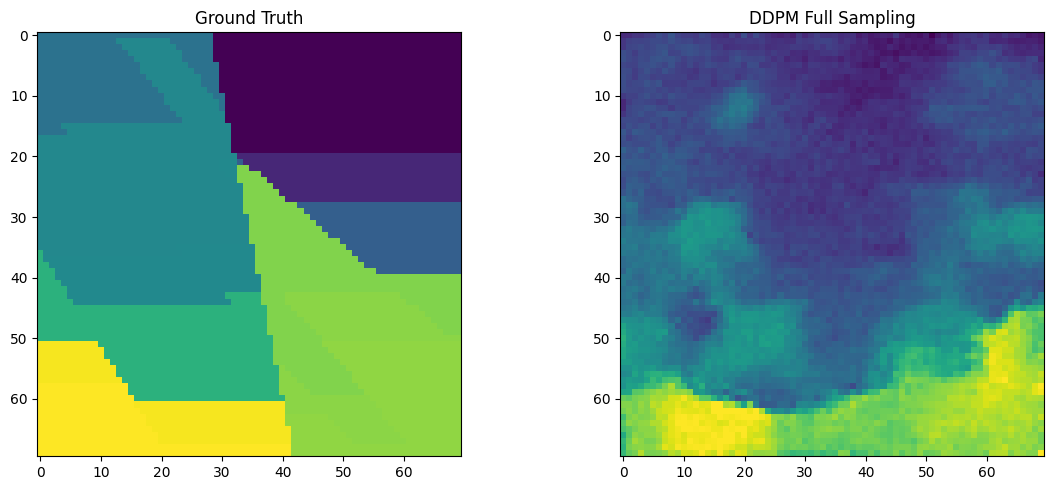

In [81]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# データ読み込み
val_ds = OpenFWIDataset("../dataset_one_batch", split="val")
wave, gt_vel = val_ds[0]
wave = wave.unsqueeze(0).to(device)
cond = wave.view(1, -1)
gt_vel = gt_vel.unsqueeze(0).to(device)

# AttentionUNetでロード
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("best_ddpm_model.pt", map_location=device))
model.eval()

# (以下、先ほどの full reverse loop コードとまったく同じ)
T = 1000
betas = linear_beta_schedule(T).to(device)
alphas = 1 - betas
alpha_cum = torch.cumprod(alphas, dim=0)
sqrt_alpha_cum    = alpha_cum.sqrt()
sqrt_one_minus_ac = (1 - alpha_cum).sqrt()
abar_prev_vec     = torch.cat([torch.tensor([1.], device=device), alpha_cum[:-1]], dim=0)

@torch.no_grad()
def p_sample(x, t, cond):
    eps_pred = model(x, t, cond)
    beta_t  = betas[t]
    alpha_t = alphas[t]
    abar_t  = alpha_cum[t]
    abar_prev = abar_prev_vec[t]

    coef = beta_t / sqrt_one_minus_ac[t]
    mean = (x - coef.view(-1,1,1,1) * eps_pred) / torch.sqrt(alpha_t).view(-1,1,1,1)

    var = beta_t * (1 - abar_prev) / (1 - abar_t)
    mask = (t > 0).float().view(-1,1,1,1)
    noise = torch.randn_like(x)
    return mean + mask * torch.sqrt(var).view(-1,1,1,1) * noise

x = torch.randn_like(gt_vel)
for ti in trange(T-1, -1, -1, desc="Reverse Sampling"):
    t = torch.full((1,), ti, device=device, dtype=torch.long)
    x = p_sample(x, t, cond)

pred = x.clamp(0,1).squeeze().cpu().numpy() * 4500
gt   = gt_vel.squeeze().cpu().numpy() * 4500

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.imshow(gt,   cmap="viridis"); ax1.set_title("Ground Truth")
ax2.imshow(pred, cmap="viridis"); ax2.set_title("DDPM Full Sampling")
plt.tight_layout()
plt.show()
